In [1]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2


# This is needed to add the repo dir to the path so jupyter
# can load the republic modules directly from the notebooks
import os
import sys
repo_name = 'republic-project'
repo_dir = os.path.split(os.getcwd())[0].split(repo_name)[0] + repo_name
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)



/Users/marijnkoolen/Code/Huygens/republic-project


In [3]:
from republic.elastic.republic_elasticsearch import initialize_es
from republic.config.republic_config import set_config_inventory_num

rep_es = initialize_es(host_type="external")




## Get overview of proposition types

In [9]:
aggs = {
    'prop_types': {
        'terms': {
            'field': 'metadata.proposition_type.keyword',
            'missing': 'N/A',
            'size': 50
        }
    }
}
    
query = {
    'bool': {
        'must': [
            {
                'range': {
                    'metadata.session_year': {
                        'gte': 1705
                    }
                }
            }
        ]
    }
}

response = rep_es.es_anno.search(index='resolution_metadata', query=query, aggs=aggs, size=0, track_total_hits=True)
response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)

other = 0
total = response['hits']['total']['value']
buckets = response['aggregations']['prop_types']['buckets']
print(f'{" ": >2} {"total": <20}{total: >8}\t{total / total: >.2f}')
print('------------------------------------')
for bi, bucket in enumerate(buckets):
    if bucket["doc_count"] / total < 0.01:
        #print('add to other:', bucket)
        other += bucket["doc_count"]
    print(f'{bi+1: >2} {bucket["key"]: <20}{bucket["doc_count"]: >8}\t{bucket["doc_count"] / total: >.2f}')
    
print(f'{" ": >2} {"other": <20}{other: >8}\t{other / total: >.2f}')


   total                 345809	1.00
------------------------------------
 1 missive               179062	0.52
 2 requeste               85114	0.25
 3 N/A                    28343	0.08
 4 rapport                14265	0.04
 5 onbekend               10882	0.03
 6 memorie                10453	0.03
 7 oraal                   5621	0.02
 8 voordracht              3607	0.01
 9 resolutie               2831	0.01
10 conclusie               1807	0.01
11 declaratie              1475	0.00
12 advies                  1135	0.00
13 rekening                 804	0.00
14 instructie               334	0.00
15 paspoort                  76	0.00
   other                   8462	0.02


Extract all proposition types:

In [28]:
prop_types = [bucket['key'] for bucket in buckets]
prop_types

['missive',
 'requeste',
 'N/A',
 'rapport',
 'onbekend',
 'memorie',
 'oraal',
 'voordracht',
 'resolutie',
 'conclusie',
 'declaratie',
 'advies',
 'rekening',
 'instructie',
 'paspoort']

### Aggregate number of resolutions per year/month/weekday

In [15]:
def make_aggs():
    return {
        'prop_type': {
            'terms': {
                'field': 'metadata.proposition_type.keyword',
                'size': 20
            }
        },
        'years': {
            'terms': {
                'field': 'metadata.session_year',
                'size': 100
            }
        },
        'months': {
            'terms': {
                'field': 'metadata.session_month',
                'size': 12
            }
        },
        'weekdays': {
            'terms': {
                'field': 'metadata.session_weekday.keyword',
            }
        }
    }


def make_prop_type_query(prop_type):
    return {
        'bool': {
            'must': [
                {'match': {'metadata.proposition_type.keyword': prop_type}}
            ]
        }
    }




In [24]:
# start from 1705, as that is the start of a consecutive range
year_range_query = {
    'range': {
        'metadata.session_year': {
            'gte': 1705
        }
    }
}


# get the aggregations query
aggs = make_aggs()

# make a query to select only missives
query = make_prop_type_query('missive')

# add the year range query (that is, only resolutions from 1705 and later)
query['bool']['must'].append(range_query)


response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)

response

{'took': 42,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 179062, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'months': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 5, 'doc_count': 17053},
    {'key': 4, 'doc_count': 15742},
    {'key': 3, 'doc_count': 15359},
    {'key': 7, 'doc_count': 15298},
    {'key': 1, 'doc_count': 15165},
    {'key': 6, 'doc_count': 15083},
    {'key': 10, 'doc_count': 14824},
    {'key': 8, 'doc_count': 14772},
    {'key': 12, 'doc_count': 14342},
    {'key': 11, 'doc_count': 14064},
    {'key': 9, 'doc_count': 13928},
    {'key': 2, 'doc_count': 13432}]},
  'weekdays': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'Lunae', 'doc_count': 47884},
    {'key': 'Veneris', 'doc_count': 38325},
    {'key': 'Martis', 'doc_count': 33838},
    {'key': 'Jovis', 'doc_count': 23840},
    

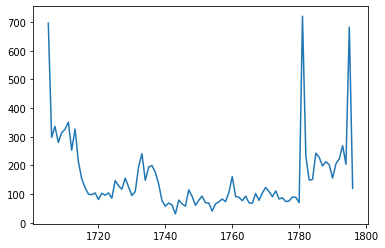

In [32]:
import matplotlib.pyplot as plt

# Get the year buckets from the aggregations
missive_buckets = response['aggregations']['years']['buckets']

# make a list of the years
years = [bucket['key'] for bucket in sorted(missive_buckets, key=lambda x: x['key'])]
# make a list of the resolution counts per year
missive_counts = [bucket['doc_count'] for bucket in sorted(missive_buckets, key=lambda x: x['key'])]


plt.plot(years, missive_counts);


In [37]:
def get_year_counts(response):
    '''convenience function to get yearly counts from aggregations'''
    buckets = response['aggregations']['years']['buckets']
    years = [bucket['key'] for bucket in sorted(buckets, key=lambda x: x['key'])]
    counts = [bucket['doc_count'] for bucket in sorted(buckets, key=lambda x: x['key'])]
    return years, counts
    

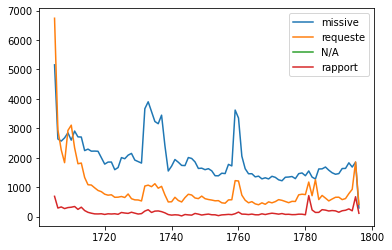

In [38]:
# iterate over proposition types and plot the yearly distribution
for prop_type in prop_types[:4]:
    query = make_prop_type_query(prop_type)
    query['bool']['must'].append(range_query)
    response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)
    years, counts = get_year_counts(response)
    plt.plot(years, counts, label=prop_type)
              
plt.legend();


## Zooming in on resolutions that contain specific keywords

In [51]:
query = {
    'bool': {
        'must': [
            {'match': {'metadata.proposition_type.keyword': prop_type}},
            range_query,
            {'terms': {'paragraphs.text': ['tijden', 'tyden']}}
        ]
    }
    
}

query

{'bool': {'must': [{'match': {'metadata.proposition_type.keyword': 'rapport'}},
   {'range': {'metadata.session_year': {'gte': 1705}}},
   {'terms': {'paragraphs.text': ['tijden', 'tyden']}}]}}

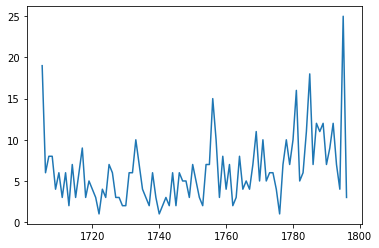

In [52]:
response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)

years, counts = get_year_counts(response)
plt.plot(years, counts, label=prop_type);


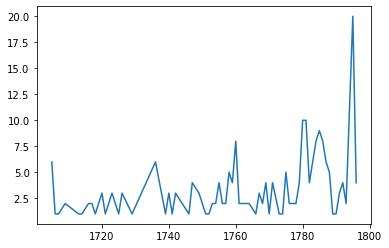

In [64]:
def make_tijden_query(tijden_terms, prop_type = None, start_year: int = 1705, end_year: int = 1796):
    query = {
        'bool': {
            'must': [
                {'range': {'metadata.session_year': {'gte': start_year, 'lte': end_year}}},
                {'terms': {'paragraphs.text': ['tijden', 'tyden']}},
                {'terms': {'paragraphs.text': tijden_terms}}
            ]
        }

    }
    if prop_type is not None:
        query['bool']['must'].append({'match': {'metadata.proposition_type.keyword': prop_type}})
    return query


tijden_terms = ['bysondere', 'byzondere']
query = make_tijden_query(tijden_terms, prop_type=None)

response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)

years, counts = get_year_counts(response)
plt.plot(years, counts, label=prop_type);



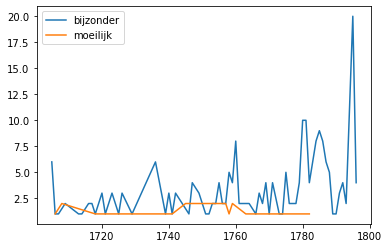

In [69]:
term_sets = {
    'bijzonder': ['bysondere', 'byzondere'],
    'moeilijk': ['bekommerlijke', 'dangereuse'],
    
}


for term_label in term_sets:
    query = make_tijden_query(term_sets[term_label], prop_type=None)
    response = rep_es.es_anno.search(index='resolutions', query=query, aggs=aggs, size=0, track_total_hits=True)
    years, counts = get_year_counts(response)
    plt.plot(years, counts, label=term_label)
    
plt.legend();
